In [1]:
from cowerc_adsorption import PhysicalParams, Simulation, ExperimentalBreakthroughData
import matplotlib.pyplot as plt
import numpy as np

from math import pi
from pathlib import Path

import pandas as pd
from scipy.optimize import Bounds, curve_fit

In [2]:
excel_file = Path("../../.data/Data and Column Properties.xlsx")
sheet_name = "PFBA PFOA Competition"

In [3]:
# Read Emma's excel report
xls_setup = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=19, usecols="A:B", index_col=0)
xls_influent = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=10, nrows=5, usecols="D:F")
xls_btc = pd.read_excel(excel_file, sheet_name=sheet_name, header=20, usecols="A:M")

In [4]:
setup = xls_setup.to_dict()["Value"]

In [5]:
porosity = setup["Bed Voidage (ε)"]
lenght = setup["Bed Length (cm)"]

area = 0.25 * pi * setup["Column Diameter (cm)"] ** 2  # cm²
pore_velocity = setup["Flow Rate (mL/min)"] / (area * porosity)  # cm/min

In [6]:
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFOA STDEV,PFOA STDEV C/C0,PFBA,PFBA C/C0,PFBA STDEV,PFBA STDEV C/C0
0,1,45.000000,74.25,256.034483,1237.500000,0.00,0.000000,0.000000,0.000000,120.50,0.115854,27.435743,0.026378
1,2,100.000000,165.00,568.965517,2750.000000,1.95,0.000694,2.050610,0.000730,429.60,0.413037,52.043059,0.050037
2,3,250.000000,412.50,1422.413793,6875.000000,83.05,0.029567,43.911331,0.015633,816.30,0.784828,20.930361,0.020123
3,4,592.424242,977.50,3370.689655,16291.666667,190.95,0.067980,48.861079,0.017395,1054.10,1.013460,84.994235,0.081717
4,5,1042.727273,1720.50,5932.758621,28675.000000,510.60,0.181779,8.485281,0.003021,1018.10,0.978848,2.969848,0.002855
5,6,1500.909091,2476.50,8539.655172,41275.000000,862.10,0.306917,35.213918,0.012537,1132.45,1.088790,21.849600,0.021007
6,7,2002.727273,3304.50,11394.827586,55075.000000,1132.35,0.403129,22.980970,0.008181,1007.35,0.968513,3.889087,0.003739
7,8,2674.242424,4412.50,15215.517241,73541.666667,1414.45,0.503560,40.375797,0.014374,974.65,0.937073,9.263099,0.008906
8,10,4039.090909,6664.50,22981.034483,111075.000000,1764.65,0.628235,19.021172,0.006772,1119.55,1.076387,172.321923,0.165678
9,12,5485.575758,9051.20,31211.034483,150853.333333,1995.40,0.710385,85.701342,0.030511,1036.90,0.996923,50.204581,0.048269


In [7]:
experimental_data = ExperimentalBreakthroughData(
    time=np.round((xls_btc["Time (min.)"] * lenght / pore_velocity), 2).to_numpy(),
    conc=xls_btc[["PFOA C/C0", "PFBA C/C0"]].to_numpy().T,
)


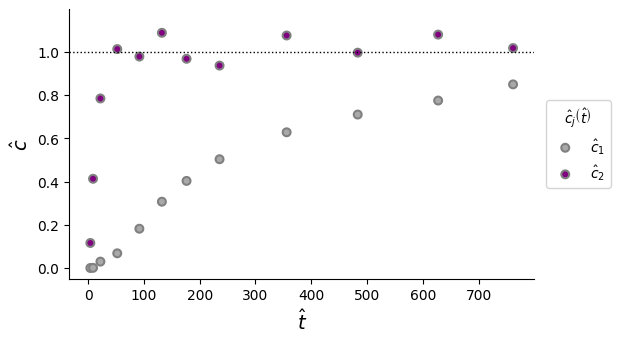

In [8]:
experimental_data.plot_breakthrough()

In [9]:
p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=5000.0,
    k_ads=(50, 50),
    k_des=(2, 0.15),
)

sim = Simulation(**p.nondim)
sim.end_time = 780
sim.solve()

Finished solve() in 7.3056 secs


In [21]:
def f(times_to_query, sm, kads_1, kads_2, kdes_1, kdes_2):
    k_ads = (kads_1, kads_2)
    k_des = (kdes_1, kdes_2)

    p = PhysicalParams(
        L=lenght,
        v=pore_velocity,
        n=porosity,
        sm=sm,
        k_ads=k_ads,
        k_des=k_des,
    )

    sim = Simulation(**p.nondim)
    sim.end_time = 780
    sim.solve()
    # display(sim.plot_breakthrough())

    # Query the btc from t
    results = sim.btc_df().loc[times_to_query].to_numpy()
    return results.flatten()


def logf(times_to_query, logsm, logkads_1, logkads_2, logkdes_1, logkdes_2):
    sm = 10**logsm
    k_ads = (10**logkads_1, 10**logkads_2)
    k_des = (10**logkdes_1, 10**logkdes_2)

    print(f"{sm=:.3E}, {k_ads[0]=:.3E}, {k_ads[1]=:.3E}, {k_des[0]=:.3E}, {k_des[1]=:.3E}")

    p = PhysicalParams(
        L=lenght,
        v=pore_velocity,
        n=porosity,
        sm=sm,
        k_ads=k_ads,
        k_des=k_des,
    )

    sim = Simulation(**p.nondim)
    sim.end_time = 780
    sim.solve()

    # Query the btc from t
    results = sim.btc_df().loc[times_to_query].to_numpy()
    return results.flatten()


In [12]:
p0 = 5000, 50, 50, 2, 0.15

fitting_result = curve_fit(
    f,
    xdata=experimental_data.time,
    ydata=experimental_data.conc.T.flatten(),
    p0=p0,
    method="lm",
    full_output=True,
)

Finished solve() in 4.9847 secs
Finished solve() in 4.9765 secs
Finished solve() in 4.8704 secs
Finished solve() in 4.9849 secs
Finished solve() in 4.8919 secs
Finished solve() in 5.0205 secs
Finished solve() in 5.0616 secs
Finished solve() in 4.9490 secs
Finished solve() in 5.0834 secs
Finished solve() in 5.0640 secs
Finished solve() in 5.0898 secs
Finished solve() in 5.4383 secs
Finished solve() in 4.8888 secs
Finished solve() in 5.0316 secs
Finished solve() in 4.9127 secs
Finished solve() in 5.0254 secs
Finished solve() in 4.8682 secs
Finished solve() in 4.8541 secs
Finished solve() in 4.9824 secs
Finished solve() in 5.0215 secs
Finished solve() in 5.0144 secs
Finished solve() in 4.8906 secs
Finished solve() in 4.8385 secs
Finished solve() in 4.9945 secs
Finished solve() in 4.8353 secs
Finished solve() in 5.0663 secs
Finished solve() in 4.8965 secs
Finished solve() in 4.8826 secs
Finished solve() in 5.0269 secs
Finished solve() in 4.8943 secs
Finished solve() in 5.0086 secs
Finished

In [13]:
fitting_result

(array([1.99660933e+08, 3.36153274e+01, 3.66563346e+01, 9.85941401e-02,
        2.83476668e+00]),
 array([[ 3.39446362e+27, -5.27451768e+12,  6.73325639e+13,
          1.21003662e+12,  9.80986945e+12],
        [-5.27451768e+12,  1.67948825e+01, -1.04627815e-01,
          5.50275240e-02, -1.52434397e-02],
        [ 6.73325639e+13, -1.04627815e-01,  8.47445628e+01,
          2.40022709e-02,  7.61322123e+00],
        [ 1.21003662e+12,  5.50275240e-02,  2.40022709e-02,
          6.62326542e-04,  3.49695837e-03],
        [ 9.80986945e+12, -1.52434397e-02,  7.61322123e+00,
          3.49695837e-03,  7.78984569e-01]]),
 {'fvec': array([ 0.05803206,  0.03963462,  0.06400247, -0.04184992,  0.05390599,
          0.02369052,  0.06100687, -0.01767179,  0.01100975,  0.02114249,
         -0.04684791, -0.08878952, -0.06905203,  0.03148738, -0.07344737,
          0.06292666, -0.02555068, -0.07638687,  0.03254642,  0.00307664,
          0.07574267, -0.08047303,  0.06384801, -0.0182194 ]),
  'nfev': 155

Finished solve() in 5.0247 secs


Simulation(Dam_ads=array([2.96223892, 3.23021756]), Dam_des=array([0.00868828, 0.24980439]), psi=array([8.53813761e-07, 3.23823695e-08]), bc=array([1, 1]))

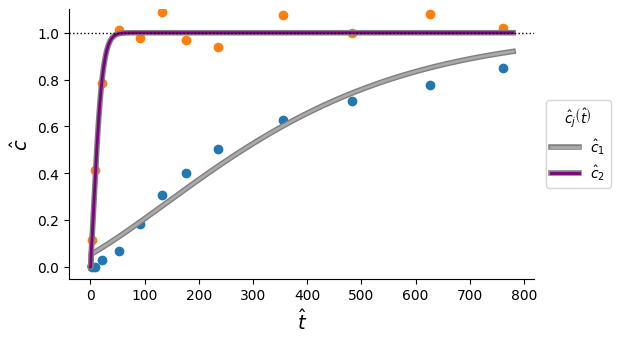

In [15]:
best_params = fitting_result[0]

p.sm = best_params[0]
p.k_ads = best_params[1:3]
p.k_des = best_params[3:5]

nsim = Simulation(**p.nondim)
nsim.end_time = 780
nsim.solve()

fig = nsim.plot_breakthrough()
ax = fig.axes[0]
ax.scatter(experimental_data.time, experimental_data.conc[0])
ax.scatter(experimental_data.time, experimental_data.conc[1])

display(nsim)
display(fig)

In [ ]:
# p0 = 5000, 50, 50, 2, 0.15
# bounds = Bounds(lb=[1, 0.0001, 0.0001, 0.0001, 0.0001], ub=[10000, 50, 50, 10, 10])

# fitting_result = curve_fit(
#     f,
#     xdata=experimental_data.time,
#     ydata=experimental_data.conc.T.flatten(),
#     p0=p0,
#     bounds=bounds,
#     method="trf",
#     loss="soft_l1",
#     full_output=True,
# )

Finished solve() in 5.0431 secs
Finished solve() in 4.9652 secs
Finished solve() in 5.0433 secs
Finished solve() in 4.9839 secs
Finished solve() in 4.9211 secs
Finished solve() in 4.9759 secs
Finished solve() in 4.8577 secs
Finished solve() in 5.0289 secs
Finished solve() in 4.9143 secs
Finished solve() in 4.9671 secs
Finished solve() in 4.8923 secs
Finished solve() in 5.0289 secs
Finished solve() in 4.8716 secs
Finished solve() in 5.0290 secs
Finished solve() in 4.8736 secs
Finished solve() in 4.9773 secs
Finished solve() in 4.9258 secs
Finished solve() in 4.9972 secs
Finished solve() in 5.1037 secs
Finished solve() in 5.0628 secs
Finished solve() in 5.0594 secs
Finished solve() in 4.8773 secs
Finished solve() in 4.7910 secs
Finished solve() in 4.9324 secs
Finished solve() in 4.8980 secs
Finished solve() in 4.9886 secs
Finished solve() in 4.8756 secs
Finished solve() in 5.0281 secs
Finished solve() in 4.8869 secs
Finished solve() in 4.8868 secs
Finished solve() in 4.9872 secs
Finished

In [24]:
logp0 = 3.70, 1.70, 1.70, 0.30, -0.83

fitting_result = curve_fit(
    logf,
    xdata=experimental_data.time,
    ydata=experimental_data.conc.T.flatten(),
    p0=logp0,
    method="lm",
    full_output=True,
)

sm=5.012E+03, k_ads[0]=5.012E+01, k_ads[1]=5.012E+01, k_des[0]=1.995E+00, k_des[1]=1.479E-01
Finished solve() in 4.9840 secs
sm=5.012E+03, k_ads[0]=5.012E+01, k_ads[1]=5.012E+01, k_des[0]=1.995E+00, k_des[1]=1.479E-01
Finished solve() in 4.9566 secs
sm=5.012E+03, k_ads[0]=5.012E+01, k_ads[1]=5.012E+01, k_des[0]=1.995E+00, k_des[1]=1.479E-01
Finished solve() in 5.0662 secs
sm=5.012E+03, k_ads[0]=5.012E+01, k_ads[1]=5.012E+01, k_des[0]=1.995E+00, k_des[1]=1.479E-01
Finished solve() in 5.1419 secs
sm=5.012E+03, k_ads[0]=5.012E+01, k_ads[1]=5.012E+01, k_des[0]=1.995E+00, k_des[1]=1.479E-01
Finished solve() in 5.3391 secs
sm=5.012E+03, k_ads[0]=5.012E+01, k_ads[1]=5.012E+01, k_des[0]=1.995E+00, k_des[1]=1.479E-01
Finished solve() in 4.8936 secs
sm=1.753E+70, k_ads[0]=2.771E+01, k_ads[1]=1.389E+01, k_des[0]=6.255E-01, k_des[1]=1.942E+01
Finished solve() in 4.9298 secs
sm=1.753E+70, k_ads[0]=2.771E+01, k_ads[1]=1.389E+01, k_des[0]=6.255E-01, k_des[1]=1.942E+01
Finished solve() in 4.8836 secs


In [25]:
fitting_result

(array([89.15138705,  1.52653738,  1.56414912, -1.00614852,  0.45251745]),
 array([[ 2.31525062e+14, -4.38360297e+05,  4.15333495e+03,
         -7.44835498e+05, -1.01066855e+04],
        [-4.38360297e+05,  3.63191459e-03, -7.86375835e-06,
          4.64879934e-03,  1.91355942e-05],
        [ 4.15333495e+03, -7.86375835e-06,  1.17080813e-02,
         -1.33616261e-05,  1.34654231e-02],
        [-7.44835498e+05,  4.64879934e-03, -1.33616261e-05,
          6.87788541e-03,  3.25140529e-05],
        [-1.01066855e+04,  1.91355942e-05,  1.34654231e-02,
          3.25140529e-05,  1.76186662e-02]]),
 {'fvec': array([ 0.05803205,  0.03963459,  0.06400246, -0.04184993,  0.05390598,
          0.02369053,  0.06100688, -0.01767181,  0.01100978,  0.02114246,
         -0.04684787, -0.08878955, -0.06905198,  0.03148736, -0.07344734,
          0.06292664, -0.02555068, -0.07638689,  0.03254638,  0.00307663,
          0.07574261, -0.08047303,  0.06384795, -0.0182194 ]),
  'nfev': 107,
  'fjac': array([[ 2.

In [26]:
[10**x for x in fitting_result[0]]

[np.float64(1.4170561331055618e+89),
 np.float64(33.61533012367165),
 np.float64(36.65634204809566),
 np.float64(0.09859422648550177),
 np.float64(2.834767560626919)]